# Data Loading and Clean up

In [50]:

# imports, we are going to use python 3 with numpy for data manuplation and maplotlib for vislization
import numpy as np
import csv
from numpy import genfromtxt
from matplotlib import pyplot as plt


In [3]:
# Read data file
# data file contains commas with in quotes, which is not handled by genfromtxt,
# so let's read them as CSV which handles quotes with in string properly and then pass it to numpy array
lines = ("\t".join(i) for i in csv.reader(open('WDIData.csv')))
raw_data = np.genfromtxt(lines, delimiter="\t", dtype=str)

# let's check if we read the data correctly
raw_data.shape, raw_data.dtype



In [40]:
# This file contains Regions along with countries, for example Arab World is Region which contains
# many countries. Let's remove these reasons.
lines = ("\t".join(i) for i in csv.reader(open('WDICountry.csv')))
all_regions = np.genfromtxt(lines, delimiter="\t", dtype=str)

# print (all_regions[0,10]) 
# National accounts base year

# 'National accounts base year' column is null for all non countries, so let's filter it out.
country_data = all_regions[all_regions[:, 10] != '', :]
valid_country_codes = country_data[1:, 0]

# Let's filter the data by these country codes only from raw data
cleaned_data = raw_data[np.in1d(raw_data[:, 1], valid_country_codes), :]

# Questions
## #1 Consider the age distribution, i.e., the fractions of the population that fall into each age bin, of the population of each country. Do you see any outlier countries with respect to the age mix of the population in the year 2016?

#### So we need to figure out for if there are countries which are outliers in the a given age distribution. We have 2 types of age distribution in the data. There is age distributions for all genders, which is divided into 3 categories: 0 - 14, 15 - 64,  65 - up.   These is also more granular age distribution in the data but for that we need combine percetanges acorss male and female data columns.  For this question, I am going to consider the first set of distribution.


In [48]:
# Let's first get the columns that we want
# First coulumn is country Name
# Fourth column is data category
# 61th columns is data for 2016 

columns = cleaned_data[:, [0, 3, 60]]

# total percentage of people under 14
under_14_category = 'SP.POP.0014.TO.ZS'
under_14 = columns[columns[:, 1] == under_14_category, :] 

# total percentage of people between 15-64
fifteen_to_64_category = 'SP.POP.1564.TO.ZS'
fifteen_to_64 = columns[columns[:, 1] == fifteen_to_64_category, :]

# total percentage of people above 65 
above_65_category = "SP.POP.65UP.TO.ZS"
above65 = columns[columns[:, 1] == above_65_category, :]

# let's join the column into single numpy array
# so final numpy array is: country name, percentage of population under 14, between 15-64, above 65
final = np.transpose(np.vstack((under_14[:, 0], under_14[:, 2], fifteen_to_64[:, 2], above65[:, 2])))
final.shape

(207, 4)

In [81]:
# Now that we have gotten the data, let's try to create a bar chart which will display 
# all countries and their peopulation % for each category, if we sort by population % we will be able
# see all the outliers. 

# we could also create a scatter chart but with so many dimensions (countries), it would be very
# hard to map legends with data

# this function will take the data and the index for age range and will plot the chart
def draw(idata, index, title):
    # let's remove countries where we don't have any data
    filtered_data = idata[idata[:, index] != '', :]
    
    # Sorting so we could plot them properly 
    sorted_data = filtered_data[filtered_data[:, index].astype(float).argsort()]
    
    fig, ax = plt.subplots()
    fig.set_size_inches(40, 10)
    ax.bar(sorted_data[:, 0], sorted_data[:,index].astype('float'))
    ax.set_yticks([0, 20, 40, 60, 80, 100])
    ax.set_title("Population by % of agne group of {} across countries".format(title))
    ax.set_xticklabels(sorted_data[:,0], rotation = 90)
    ax.set_xlabel('Countries')
    ax.set_ylabel('Population')
    plt.show()

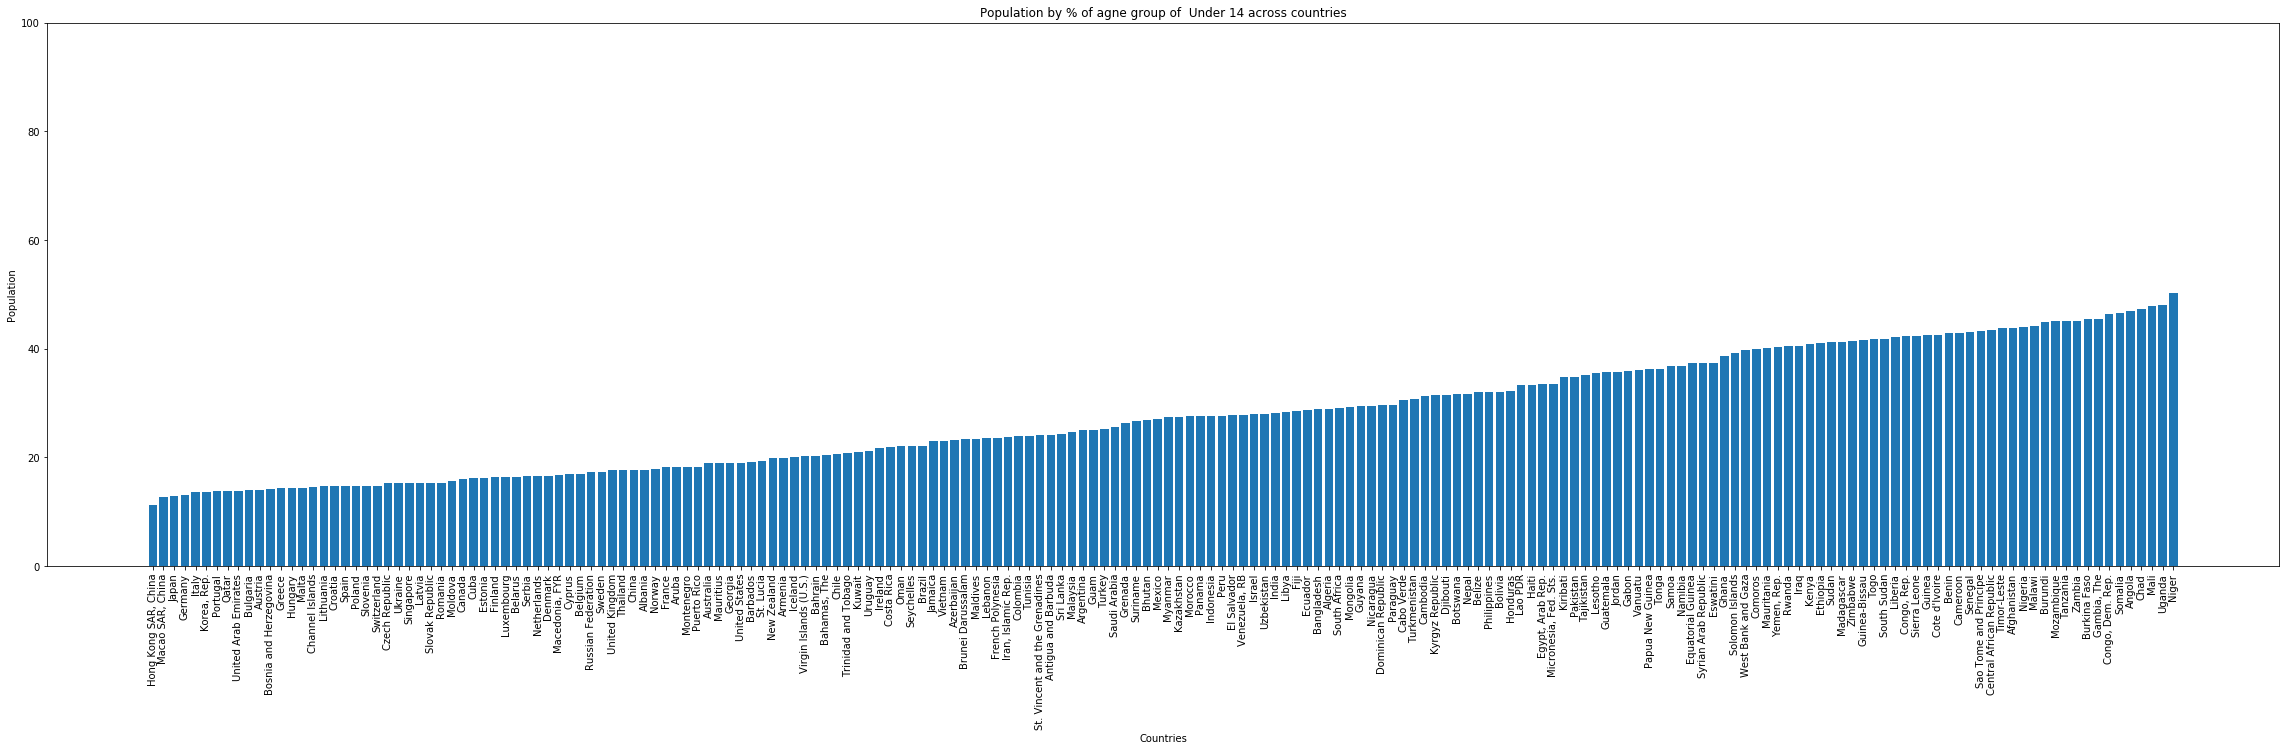

In [85]:
# create Chart for Population group of under 14
draw(final, 1, ' Under 14')

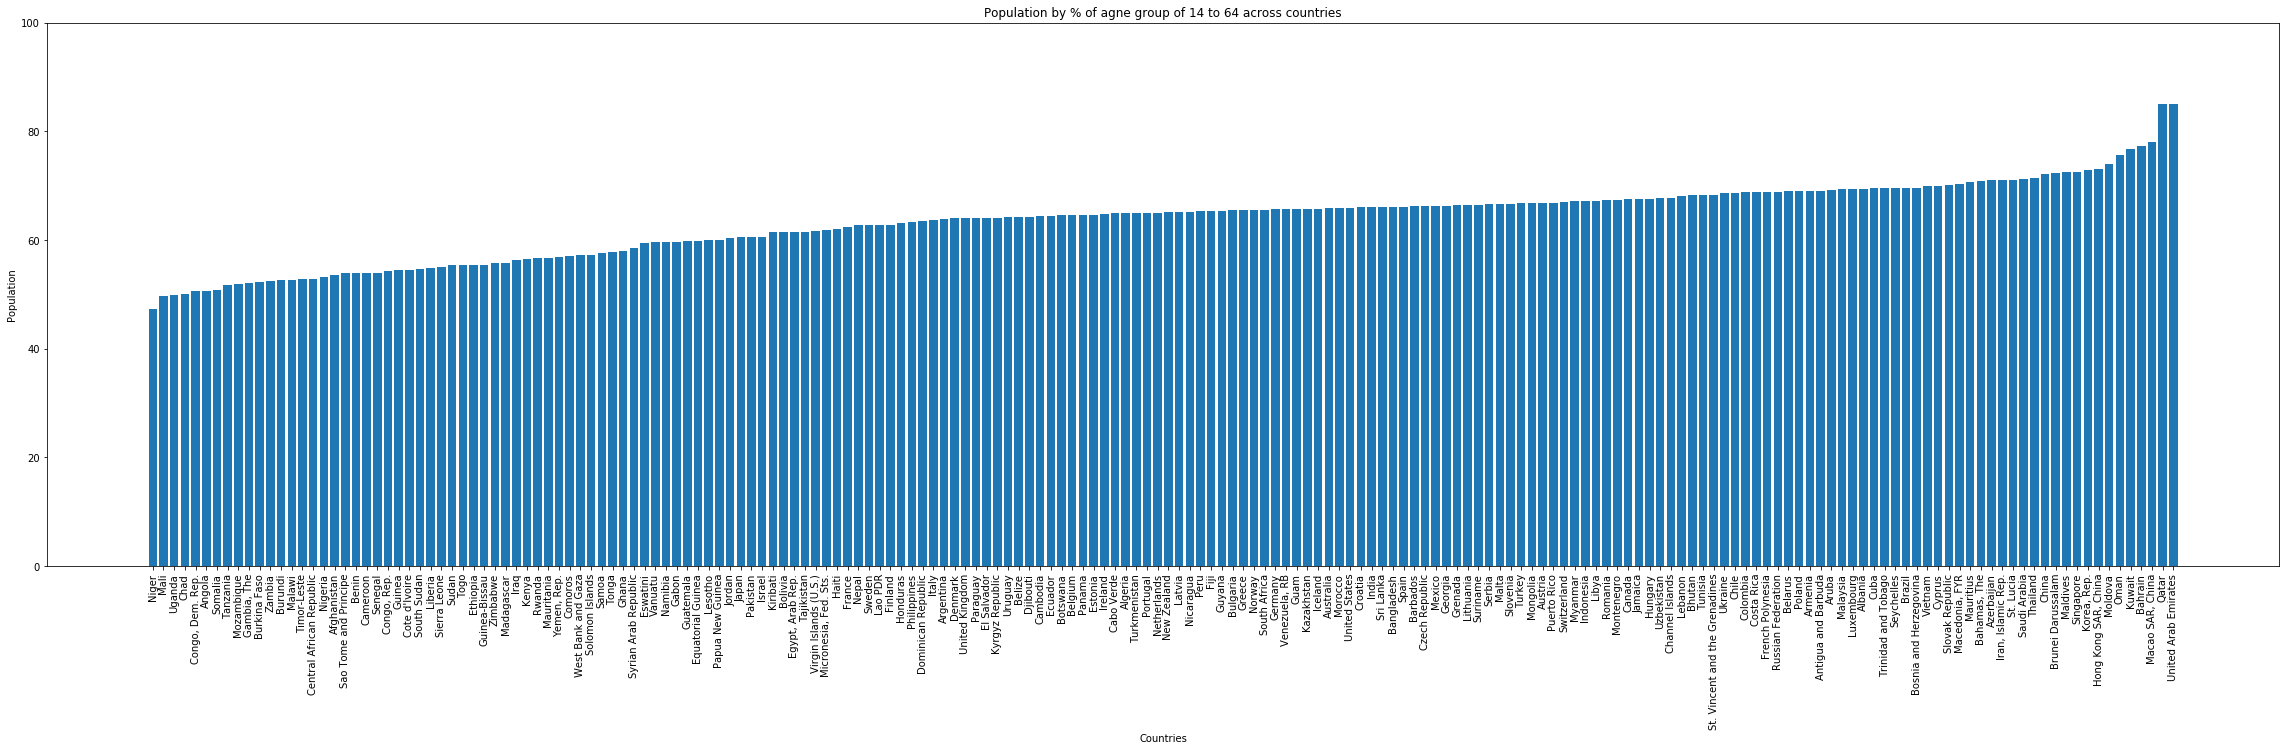

In [83]:
# create Chart for Population group of 15 to 64 year old
draw(final, 2, '14 to 64')

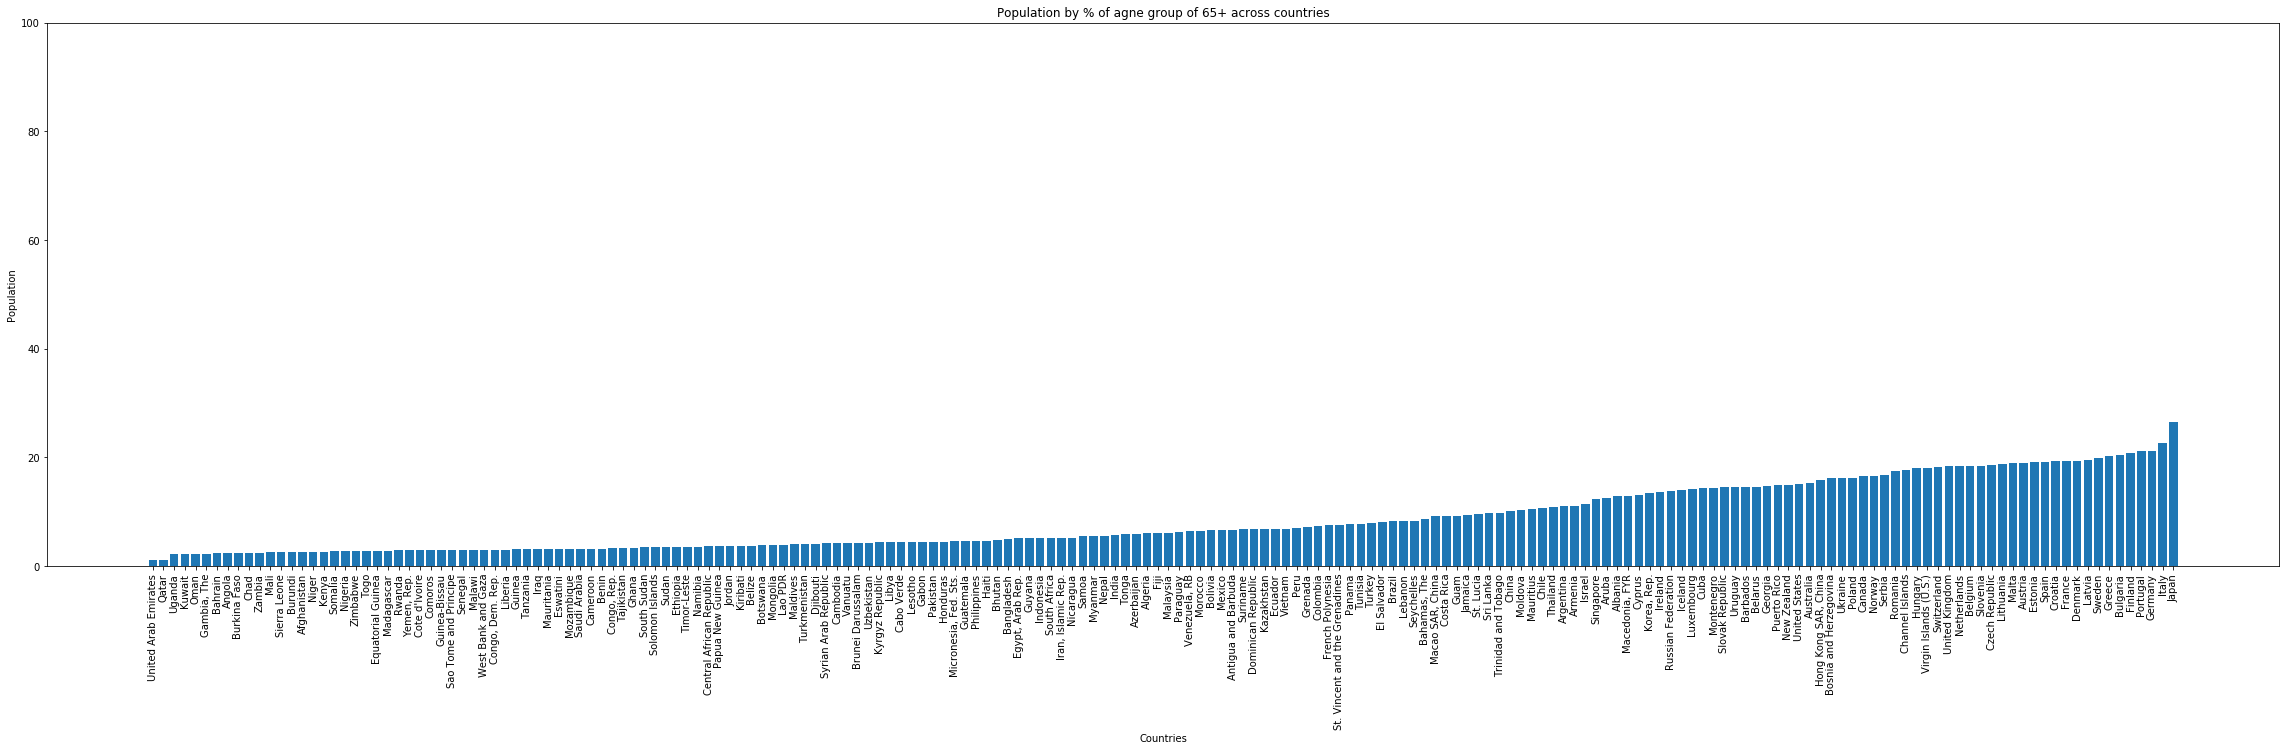

In [84]:
# create Chart for Population group of 65 year olds
draw(final, 3, '65+')

### As we can see in these Charts that for
- Population above 65: Japan clearly is outlier and most again population, while UAE very very few people in this age range
- Population between 15-64:  UAE and Qater seem to outlier for this age group
- Population under 14:  Though Nigar and Uganda has highest number of people under age of 14, they doesn't seem to too out of range to be called outlier

## Question#2. Which countries show the largest difference between the age distributions of male and female populations in 2016?

### For male vs Female age distribution we have 15 categories and we will try to find the largest difference between agent distrution between maile and female amount each.   We need to make sure we considar largest difference on both side, i.e., when there are too many males and when there are too many females. 

### we will plot a horizontal bar chart for top 5 counties with higest difference in each of the category.

In [96]:
# let's first create a dict of categories with age range and indicators for female population % and male population %
categories = [
    ('0-14',  'SP.POP.0014.FE.ZS', 'SP.POP.0014.MA.ZS'),
    ('15-19', 'SP.POP.1519.FE.5Y', 'SP.POP.1519.MA.5Y'),
    ('20-24', 'SP.POP.2024.FE.5Y', 'SP.POP.2024.MA.5Y'),
    ('25-29', 'SP.POP.2529.FE.5Y', 'SP.POP.2529.MA.5Y'),
    ('30-34', 'SP.POP.3034.FE.5Y', 'SP.POP.3034.MA.5Y'),
    ('35-39', 'SP.POP.3539.FE.5Y', 'SP.POP.3539.MA.5Y'),
    ('40-44', 'SP.POP.4044.FE.5Y', 'SP.POP.4044.MA.5Y'),
    ('45-49', 'SP.POP.4549.FE.5Y', 'SP.POP.4549.MA.5Y'),
    ('50-54', 'SP.POP.5054.FE.5Y', 'SP.POP.5054.MA.5Y'),
    ('55-59', 'SP.POP.5559.FE.5Y', 'SP.POP.5559.MA.5Y'),
    ('60-64', 'SP.POP.6064.FE.5Y', 'SP.POP.6064.MA.5Y'),
    ('65-69', 'SP.POP.6569.FE.5Y', 'SP.POP.6569.MA.5Y'),
    ('70-74', 'SP.POP.7074.FE.5Y', 'SP.POP.7074.MA.5Y'),
    ('75-79', 'SP.POP.7579.FE.5Y', 'SP.POP.7579.MA.5Y'),
    ('80 and Above','SP.POP.80UP.FE.5Y', 'SP.POP.80UP.MA.5Y' )
]

# Since we will be plotting the chart for multiple categories, let's create a function which 
# take indicators for female population % and male population % in each category
# and return top 5 Contries with different in female population vs male population percentage.
def per_cat_diff(f_cat, m_cat):
    # 4th column contains the indicator in cleaned data. Let's subset the numpy array, so we only get rows for
    # female category
    # 61th column contains the values for 2016
    required_data = cleaned_data[:, [0, 60]]
    
    female = required_data[cleaned_data[:, 3] == f_cat, :]

    # let's do the same for mail category
    male = required_data[cleaned_data[:, 3] == m_cat, :]

    # let's merge the data so we have country, female population, male population 
    q2_data = np.transpose(np.vstack((female[:, 0], female[:, 1], male[:, 1])))
    
    # let's filter the array and remove null values. 
    filtered_data = q2_data[(q2_data[:, 1] != '') | (q2_data[:, 2] != ''),:]

    # let's calculate different between female and mail population
    diff = filtered_data[:, 1].astype(float) - filtered_data[:, 2].astype(float)
    
    # let's created a merged array which contains diff of population and absolute diff of population
    merged = np.transpose(
        np.vstack(
            (filtered_data[:,0], filtered_data[:,1], filtered_data[:,2], diff, np.absolute(diff))
        )
    )
    
    # let's sort the array 
    sorted_data = merged[merged[:, 4].astype(float).argsort()]
    
    # top 5 countries with difference 
    top_5 = sorted_data[-5:,:4]
    
    return top_5


<Figure size 432x288 with 0 Axes>

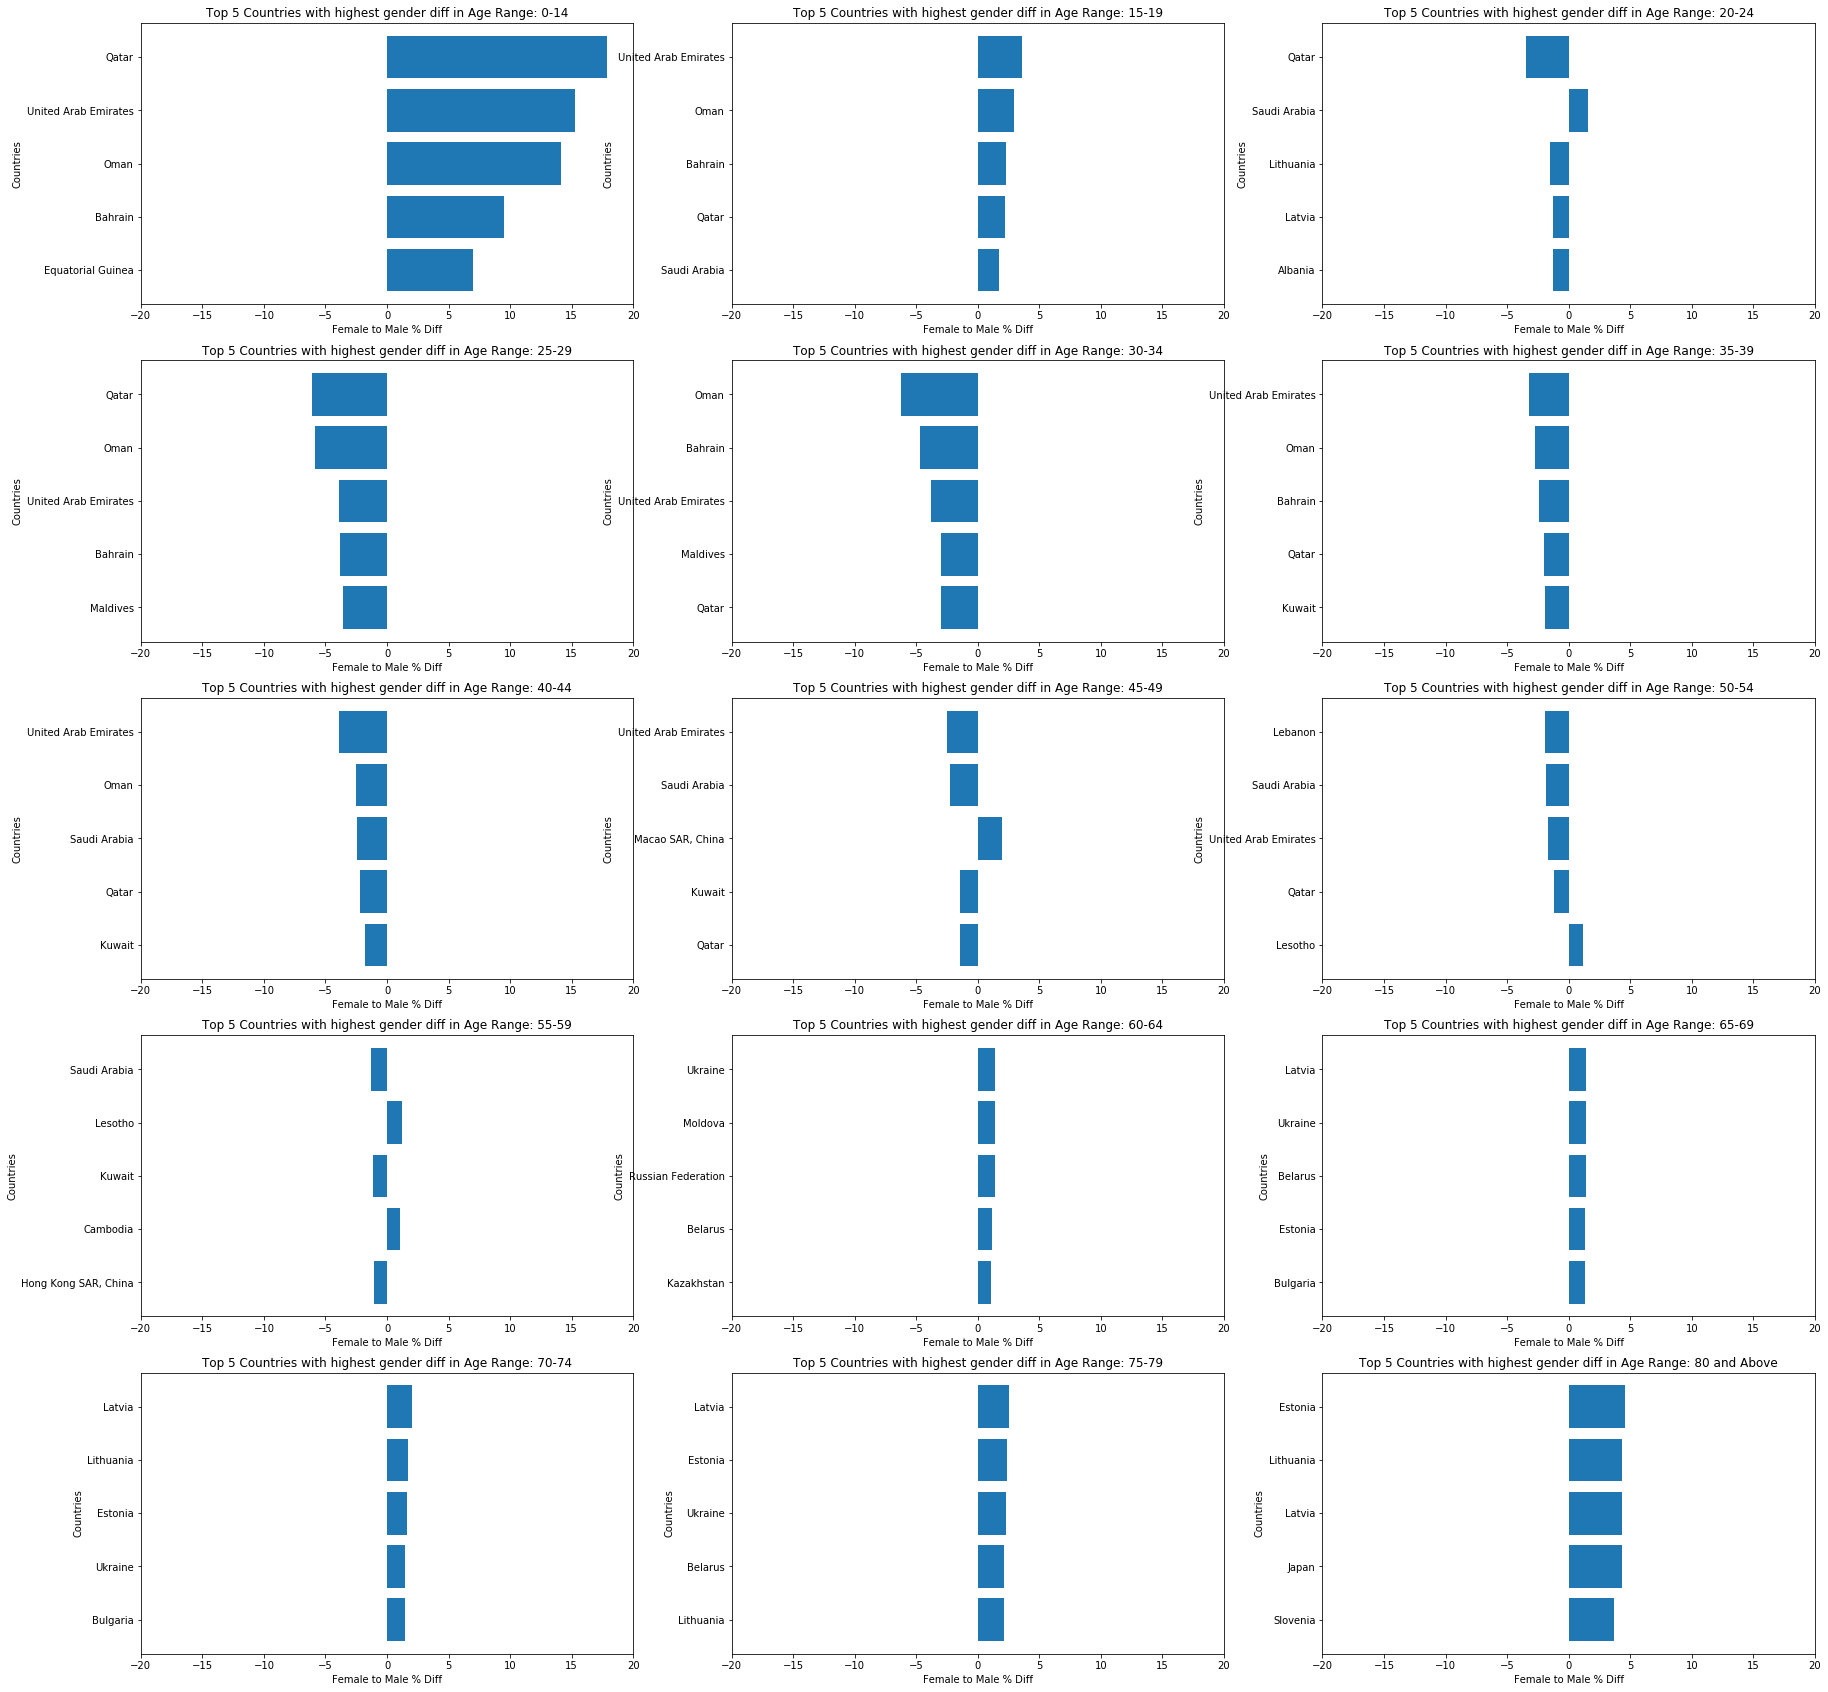

In [98]:
# Now we have gathered the data let's create the chart.

# I am going to create 5 by 3 subplots to plot these 15 categories. 

plt.figure(1)
fig, axes = plt.subplots(5, 3)
fig.set_size_inches(30, 30)
for i, (name, f_cat, m_cat) in enumerate(categories):
    # fetching data for each category
    result = per_cat_diff(f_cat, m_cat)
    
    # falttening the axies to it is easier to access it (axes is a 5,3 nparray)
    ax = axes.flatten()[i]

    # plotting countries against differece in population 
    ax.barh(result[:,0], result[:,3].astype('float'), align='center')
    ax.set_xticks(range(-20, 25, 5))
    ax.set_xlabel('Female to Male % Diff')
    ax.set_ylabel('Countries')
    ax.set_xlim(-20, 20)
    ax.set_title("Top 5 Countries with highest gender diff in Age Range: {}".format(name))

# finally plot the figure
plt.show()

### This data show some very interesting insights
- We can see the male to female population difference across all age group.
- It is not always the case that in all group males are more than females. 
- Qatar, UAE, Oman and Saudi Arabia consistently seem to highest gender difference between age group of 50
- Latvia, Lithuania and Estonia seem to have higest gender difference post the age group of 50. 

## Question#3: Do you see an association between the age distribution of the population and mobile phone adoption? How about fixed telephone subscriptions?

### To figure out if their is an assoication between the age distribution and mobile phone adoption, I am going to figure out if there correlation between a given population group and mobile phone adoption

In [104]:
# let's create a function which can take two attribute indicators and calculat correlation coefficient between the two.
def calculate_corr_coefficient(cat1, cat2):
    # get per year for indicator1 (category1)
    # 4th column is the category
    # let's take data for last 10 years
    cat1_by_year = cleaned_data[cleaned_data[:,3] == cat1, 50:]
    
    # get per year data for indicator2 (category2)
    cat2_by_year = cleaned_data[cleaned_data[:,3] == cat2, 50:]
    
    # let's fill empty values with zero
    cat1_by_year[cat1_by_year == ''] = '0'
    cat2_by_year[cat2_by_year == ''] = '0'
    
    # calculat the correlation coefficient 
    corr = np.corrcoef(cat1_by_year.astype(float).flatten(), cat2_by_year.astype(float).flatten())
    return (corr[0,1])

# Let's find out correlation between difference population group vs mobile phone adoption.
print ('0-14 population group vs mobile phone adoption:', calculate_corr_coefficient("IT.CEL.SETS.P2", "SP.POP.0014.TO.ZS"))
print ('15-64 population group vs mobile phone adoption :', calculate_corr_coefficient("IT.CEL.SETS.P2", "SP.POP.1564.TO.ZS"))
print ('65+ population group vs mobile phone adoption   :', calculate_corr_coefficient("IT.CEL.SETS.P2", "SP.POP.65UP.TO.ZS"))

0-14 population group vs mobile phone adoption: -0.08551215551464304
15-64 population group vs mobile phone adoption : 0.5053421096175562
65+ population group vs mobile phone adoption   : 0.5003898415596628


In [105]:
# Let's find out correlation between difference population group vs telephone subscriptions.
print ('0-14 population group vs landline subscriptions:', calculate_corr_coefficient("IT.MLT.MAIN.P2", "SP.POP.0014.TO.ZS"))
print ('15-64 population group vs landline subscriptions:', calculate_corr_coefficient("IT.MLT.MAIN.P2", "SP.POP.1564.TO.ZS"))
print ('65+ population group vs landline subscriptions:', calculate_corr_coefficient("IT.MLT.MAIN.P2", "SP.POP.65UP.TO.ZS"))

0-14 population group vs landline subscriptions: -0.4194417737997599
15-64 population group vs landline subscriptions: 0.14623127831609828
65+ population group vs landline subscriptions: 0.5540165086348465


### As we can see above that their is negative correlation between the age group of under 14 (mostly they don't really have any cellphone),  But there is a good correlation between the age group above 15.

### As For landline subscriptions, we can clearly see that only the age group above 65 has a association with landline subscriptions